In [1]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from tensorflow import keras

In [2]:
# set the random seed:
RANDOM_SEED = 77
random.seed(RANDOM_SEED)

TRAIN_DIR = '/kaggle/input/airbus-ship-detection/train_v2/'
TEST_DIR = '/kaggle/input/airbus-ship-detection/test_v2/'

# Read Data Set

In [3]:
df = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")
df['EncodedPixels'] = df['EncodedPixels'].astype('string')

# Delete corrupted images
CORRUPTED_IMAGES = ['6384c3e78.jpg']
df = df.drop(df[df['ImageId'].isin(CORRUPTED_IMAGES)].index)

# Dataframe that contains the segmentation for each ship in the image. 
instance_segmentation = df

# Dataframe that contains the segmentation of all ships in the image.
image_segmentation = df.groupby(by=['ImageId'])['EncodedPixels'].apply(lambda x: np.nan if pd.isna(x).any() else ' '.join(x)).reset_index()

# Utils

In [4]:
def rle_to_mask(rle: str, shape=(768, 768)):
    '''
    :param rle: run length encoded pixels as string formated
           shape: (height,width) of array to return 
    :return: numpy 2D array, 1 - mask, 0 - background
    '''
    encoded_pixels = np.array(rle.split(), dtype=int)
    starts = encoded_pixels[::2] - 1
    ends = starts + encoded_pixels[1::2]
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def mask_to_rle(img, shape=(768, 768)) -> str:
    """
    :param img: numpy 2D array, 1 - mask, 0 - background
           shape: (height,width) dimensions of the image 
    :return: run length encoded pixels as string formated
    """
    img = cv2.resize(img, shape, interpolation=cv2.INTER_AREA)
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Data preprocessing

In [5]:
IMAGES_WITHOUT_SHIPS_NUMBER = 30000

TRAIN_LENGTH = image_segmentation.shape[0]
VALIDATION_LENGTH = 1000
BATCH_SIZE = 32
BUFFER_SIZE = 10000
IMG_SHAPE = (128, 128)

In [6]:
# reduce the number of images without ships
images_without_ships = image_segmentation[image_segmentation['EncodedPixels'].isna()]['ImageId'].values[:IMAGES_WITHOUT_SHIPS_NUMBER]
images_with_ships = image_segmentation[image_segmentation['EncodedPixels'].notna()]['ImageId'].values
images_list = np.append(images_without_ships, images_with_ships)

# remove corrupted images
images_list = np.array(list(filter(lambda x: x not in CORRUPTED_IMAGES, images_list)))
    
images_list = tf.data.Dataset.list_files([f'{TRAIN_DIR}{name}' for name in images_list])

2022-09-10 20:28:28.605666: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
def load_train_image(tensor) -> tuple:
    path = tf.get_static_value(tensor).decode("utf-8")

    image_id = path.split('/')[-1]
    input_image = cv2.imread(path)
    input_image = tf.image.resize(input_image, IMG_SHAPE)
    input_image = tf.cast(input_image, tf.float32) / 255.0

    encoded_mask = image_segmentation[image_segmentation['ImageId'] == image_id].iloc[0]['EncodedPixels']
    input_mask = np.zeros(IMG_SHAPE + (1,))
    if not pd.isna(encoded_mask):
        input_mask = rle_to_mask(encoded_mask)
        input_mask = cv2.resize(input_mask, IMG_SHAPE, interpolation=cv2.INTER_AREA)
        input_mask = np.expand_dims(input_mask, axis=2)

    return input_image, input_mask

train_images = images_list.map(lambda x: tf.py_function(load_train_image, [x], [tf.float32, tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)

validation_dataset = train_images.take(VALIDATION_LENGTH) 
train_dataset = train_images.skip(VALIDATION_LENGTH)

train_batches = (
    train_dataset
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

# UNet segmentation model

In [8]:
import keras.backend as K

class UNetModel:
    def __init__(self, input_shape=(128, 128, 3)):
        self._model = self._build_model(input_shape)

    @property
    def model(self) -> tf.keras.Model:
        return self._model
    
    def _build_model(self, input_shape) -> tf.keras.Model:
        inputs = tf.keras.layers.Input(shape=input_shape)

        # apply Encoder
        skips = self._encoder(input_shape)(inputs)
        x = skips[-1]
        skips = reversed(skips[:-1])

        # apply Decoder and establishing the skip connections
        x = self._decoder(skips, x)

        # This is the last layers of the model
        last = tf.keras.layers.Conv2DTranspose(
          filters=20, kernel_size=3, strides=2, padding='same')  # 64x64 -> 128x128
        x = last(x)
        outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

        return tf.keras.Model(inputs=inputs, outputs=outputs)
    
    def _encoder(self, input_shape):
        base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

        # Use the activations of these layers
        layer_names = [
            'block_1_expand_relu',   # 64x64
            'block_3_expand_relu',   # 32x32
            'block_6_expand_relu',   # 16x16
            'block_13_expand_relu',  # 8x8
            'block_16_project',      # 4x4
        ]
        base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

        # Create the feature extraction model
        encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
        encoder.trainable = True
        return encoder
    
    def _decoder(self, skips, encoder_output):
        decoder_stack = [
            self._upsample_block(512, 3),  # 4x4 -> 8x8
            self._upsample_block(256, 1),  # 8x8 -> 16x16
            self._upsample_block(128, 3),  # 16x16 -> 32x32
            self._upsample_block(64, 1),   # 32x32 -> 64x64
        ]
        
        x = encoder_output
        for block, skip in zip(decoder_stack, skips):
            x = block(x)
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])
        
        return x
    
    def _upsample_block(self, filters, size, apply_dropout=False):
        """Upsamples an input. Conv2DTranspose => Batchnorm => Dropout => Relu
            :param:
                filters: number of filters
                size: filter size
                apply_dropout: If True, adds the dropout layer
            :return: Upsample Sequential Model
        """
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(
          tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          use_bias=False))
        result.add(tf.keras.layers.BatchNormalization())
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.5))
        result.add(tf.keras.layers.ReLU())
        return result
    

def dice_loss(targets, inputs, smooth=1e-6):
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(K.dot(targets, inputs))
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

# Intersection over Union for Objects
def IoU(y_true, y_pred, tresh=1e-10):
    axis = [1,2,3]
    Intersection = K.sum(y_true * y_pred, axis=axis)
    Union = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) - Intersection
    return K.mean( (Intersection + tresh) / (Union + tresh), axis=0)

def IoU_loss(y_true, y_pred):
    return 1 - IoU(y_true, y_pred)

9420800/9406464 [==============================] - 0s 0us/step


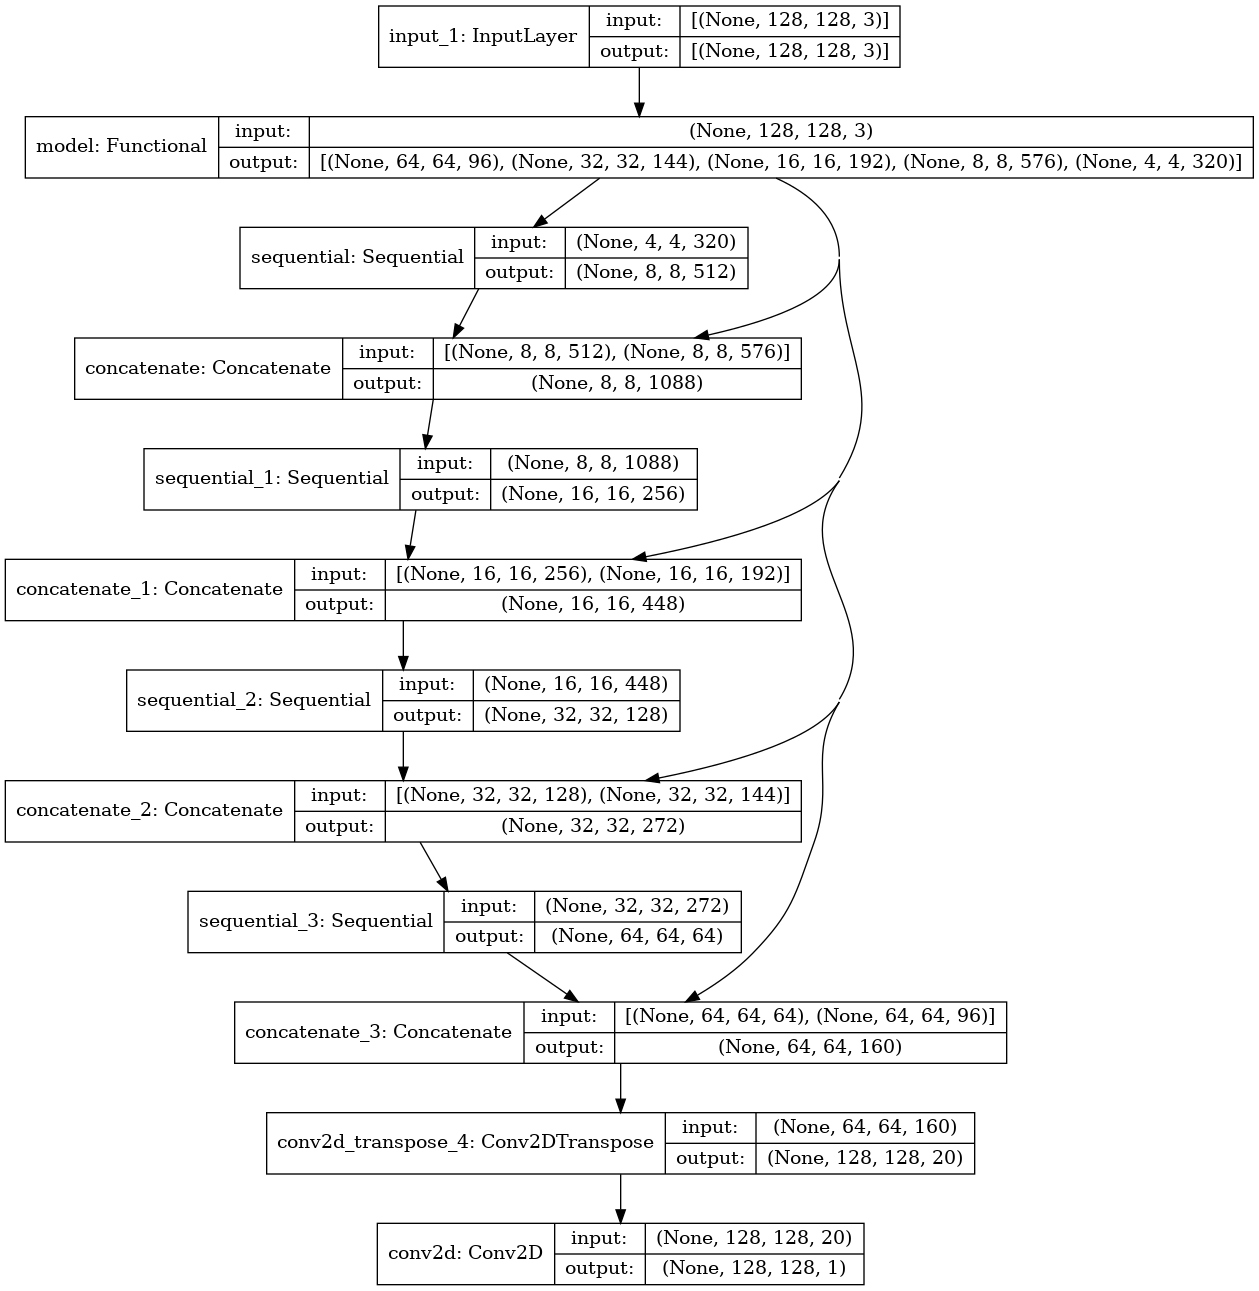

In [9]:
model = UNetModel(IMG_SHAPE + (3,)).model
model.compile(optimizer='adam', 
              loss=IoU_loss,
              metrics=[])
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
EPOCHS = 20
STEPS_PER_EPOCH = 1000

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,)


Epoch 1/20


2022-09-10 20:29:50.777956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-10 20:30:11.290219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 10000
2022-09-10 20:30:13.693429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 143 of 10000
2022-09-10 20:30:23.693535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 716 of 10000
2022-09-10 20:30:33.744158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1292 of 10000
2022-09-10 20:30:43.739468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1877 of 10000
2022-09-10 20:30:53.698619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling 

1000/1000 [==============================] - 1842s 2s/step - loss: 0.7567
Epoch 2/20
1000/1000 [==============================] - 1655s 2s/step - loss: 0.5045
Epoch 3/20
1000/1000 [==============================] - 1629s 2s/step - loss: 0.5121
Epoch 4/20
1000/1000 [==============================] - 1639s 2s/step - loss: 0.4980
Epoch 5/20
1000/1000 [==============================] - 1649s 2s/step - loss: 0.5052
Epoch 6/20
1000/1000 [==============================] - 1637s 2s/step - loss: 0.5025
Epoch 7/20
1000/1000 [==============================] - 1660s 2s/step - loss: 0.4996
Epoch 8/20
1000/1000 [==============================] - 1629s 2s/step - loss: 0.4992
Epoch 9/20
1000/1000 [==============================] - 1650s 2s/step - loss: 0.4964
Epoch 10/20
1000/1000 [==============================] - 1631s 2s/step - loss: 0.4990
Epoch 11/20
1000/1000 [==============================] - 1645s 2s/step - loss: 0.5031
Epoch 12/20
1000/1000 [==============================] - 1626s 2s/step - l

In [11]:
model.save_weights('/kaggle/working/checkpoints/model-checkpoint')

# Results analysis

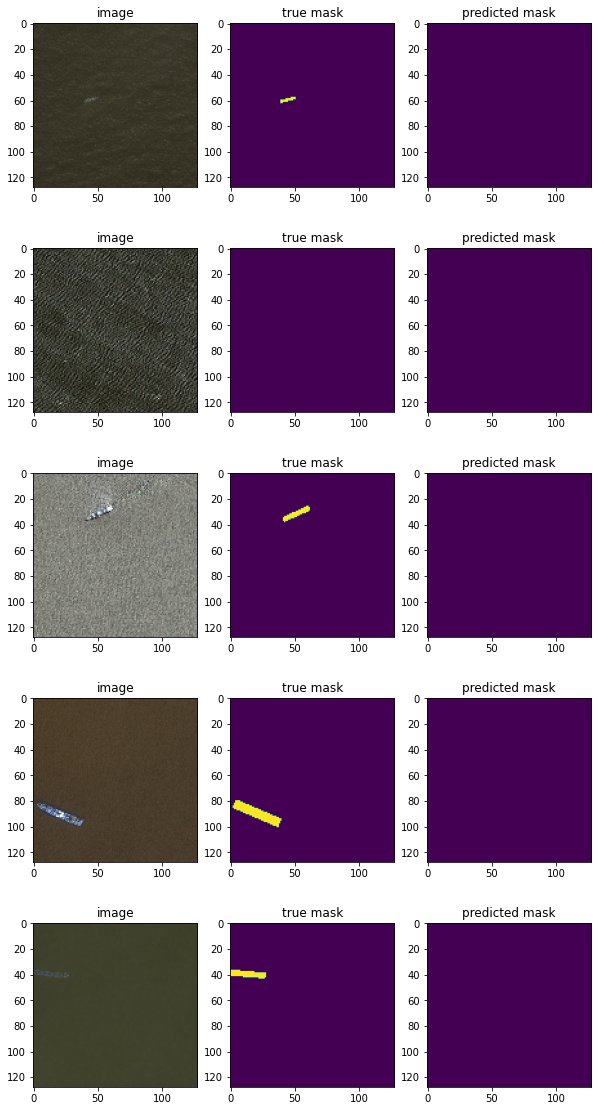

In [12]:
N = 5

f,ax = plt.subplots(N, 3, figsize=(10, 4 * N))
i = 0
for image, mask in validation_dataset.take(N):
    ax[i, 0].imshow(image)
    ax[i, 0].set_title('image')
    ax[i, 1].imshow(mask)
    ax[i, 1].set_title('true mask')

    image = np.expand_dims(image, axis=0)
    pred_mask = model.predict(image)[0]
    ax[i, 2].imshow(pred_mask)
    ax[i, 2].set_title('predicted mask')
    i += 1

plt.show()

(array([541.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 459.]),
 array([1.1600928e-13, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

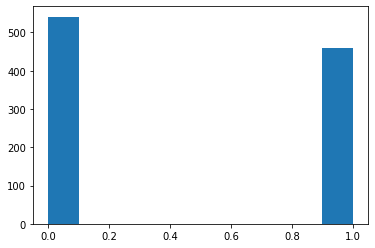

In [13]:
IoU_results = []
for image, true_mask in validation_dataset.take(VALIDATION_LENGTH):
    image = np.expand_dims(image, axis=0)
    true_mask = np.expand_dims(true_mask, axis=0)
    pred_mask = model.predict(image)[0]
    pred_mask = np.expand_dims(pred_mask, axis=0)
    IoU_results.append(tf.get_static_value(IoU(true_mask, pred_mask)))

plt.hist(IoU_results, bins=10)